# Working with source-receptor matrices using https://inmap.run and GeoPandas in Python

Air pollution source-receptor matrices give relationships between emissions at source locations and concentrations at receptor locations.
This tutorial demonstrates how to use source-receptor matrices to estimate health impacts of air pollution emissions.

## Introduction

Source-receptor (SR) matrices can allow users to get results similar to those that would be produced by running an air quality model simulation, but without having to actually run an air quality model simulation. In this tutorial, we will learn how to work with the SR matrices described in these two papers:

* Jinhyok Heo, Peter J. Adams, H. Gao (2017) Public Health Costs Accounting of Inorganic PM<sub>2.5</sub> Pollution in Metropolitan Areas of the United States Using a Risk-Based Source-Receptor Model, <i>Environment International</i>, 106, 119–126. ([link](https://barney.ce.cmu.edu/~jinhyok/apsca/))

* Andrew L. Goodkind, Christopher W. Tessum, Jay S. Coggins, Jason D. Hill, Julian D. Marshall (2019) Fine-scale damage estimates of particulate matter air pollution reveal opportunities for location-specific mitigation of emissions. <i>Proceedings of the National Academy of Sciences</i>. ([link](https://www.pnas.org/content/early/2019/04/02/1816102116.short))

We will refer to the SR matrix from the first paper as APSCA, and the one from the second paper as ISRM.

Although SR matrices are typically easier to use than full air quality models, they are often made up of files that can be hundreds of gigabytes in size, and it can be complicated to get estimates of emissions into the correct format to use with the SR matrix.
We have developed some tools to get around these limitations: the website https://inmap.run hosts the SR matrices described in the two papers above and provides functionality for taking emissions in [shapefile](https://doc.arcgis.com/en/arcgis-online/reference/shapefiles.htm) format, running them through an SR matrix, and returning the result as a shapefile.
Additionally, the [`inmap cloud`](https://inmap.run/docs/cmd/inmap_cloud/) command-line tool allows users to interact with the https://inmap.run website.

Because not all users may be comfortable using command-line tools or shapefiles, we will demonstrate here how to use the [GeoPandas](http://geopandas.org/) library in the [Python](https://www.python.org/) scripting and programming language to interact with https://inmap.run, which will hopefully provide an additional level of convenience.

If you prefer, a working [Jupyter notebook](https://jupyter.org/) version of this tutorial is available [here](https://github.com/spatialmodel/inmap/blob/master/website/static/blog/2019-04-20-sr/sr_example.ipynb).

## Set up environment

The code below is some boilerplate to make this work with either Python version 2 or 3.

In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
from builtins import *

## Prepare emissions

For this example, we are going to estimate the air pollution-related health impacts of electricity generation in the United States.
To do this we will start with emissions data from the US EPA's [National Emissions Inventory](https://www.epa.gov/air-emissions-modeling/emissions-modeling-platforms) for [year 2016](https://www.epa.gov/air-emissions-modeling/2016-alpha-platform).

The tools at https://inmap.run require input data containing:
* information on the location of the emissions source (required, in the form of either a point, line, or polygon geometry with a [spatial reference](https://en.wikipedia.org/wiki/Spatial_reference_system) specified), 
* amounts of emissions (optional, allowed emission types are VOC, NOx, NH3, SOx, and PM2_5; units must be either short tons per year, kilograms per year, or micrograms per second), and
* (smoke) stack parameters relevant to plume rise, which is how high up the emissions go immediately after they are released (optional; allowed parameters are "height", "diam", "temp", and "velocity" in units of m, m, K, and m/s, respectively).

The NEI data we are downloading includes, among other things, all of the information above. More information about the file format is available [here](https://www.cmascenter.org/smoke/documentation/4.5/html/ch08s02s08.html#sect_input_ptinv_ff10).

Although there are a number of ways to process spatial data using Python, for this exercise we will use the [GeoPandas](http://geopandas.org/) library. Instructions for installing GeoPandas are [here](http://geopandas.org/install.html).

The code below downloads the emissions data from the EPA and converts it into a GeoPandas dataframe. Keep in mind that if you have a different type of emissions data that you want to use, you may want to use a different method for importing it.
In general, the tools we work with here are for estimating the concentration and health impacts of pollutant emissions, not for estimating the emissions themselves.

In [2]:
# Note: This step can take a while to run.

from io import BytesIO, TextIOWrapper
from zipfile import ZipFile
import urllib.request
import csv
from shapely.geometry import Point
import geopandas as gpd

# Download file from EPA website.
url = urllib.request.urlopen("ftp://newftp.epa.gov/air/emismod/2016/alpha/2016fd/emissions/2016fd_inputs_point.zip")

VOC, NOx, NH3, SOx, PM2_5 = [], [], [], [], []
height, diam, temp, velocity = [], [], [],  []
coords = []

def add_record(row):
    """ Process one row of the emissions file """
    pol = row[12] # The pollutant is in the 13th column of the CSV file
                  # (In Python, the first column is called column 0.)
    emis = row[13] # We are only extracting annual total emissions here. 
                   # If monthly emissions are reported, we'll miss them.
                   # Emissions are short tons/year.
    if emis == '': return
    if pol in ['VOC', 'VOC_INV', 'XYL', 'TOL', 'TERP', 'PAR', 'OLE', 'NVOL', 'MEOH', 
               'ISOP', 'IOLE', 'FORM', 'ETOH', 'ETHA', 'ETH', 'ALD2', 'ALDX', 'CB05_ALD2', 
               'CB05_ALDX', 'CB05_BENZENE', 'CB05_ETH', 'CB05_ETHA', 'CB05_ETOH', 
               'CB05_FORM', 'CB05_IOLE', 'CB05_ISOP', 'CB05_MEOH', 'CB05_OLE', 'CB05_PAR', 
               'CB05_TERP', 'CB05_TOL', 'CB05_XYL', 'ETHANOL', 'NHTOG', 'NMOG', 'VOC_INV']:
        VOC.append(float(emis))
        NOx.append(0)
        NH3.append(0)
        SOx.append(0)
        PM2_5.append(0)
    elif pol in ['PM25-PRI', 'PM2_5', 'DIESEL-PM25', 'PAL', 'PCA', 'PCL', 'PEC', 'PFE', 'PK', 
                'PMG', 'PMN', 'PMOTHR', 'PNH4', 'PNO3', 'POC', 'PSI', 'PSO4', 'PTI']:
        VOC.append(0)
        NOx.append(0)
        NH3.append(0)
        SOx.append(0)
        PM2_5.append(float(emis))
    elif pol in ['NOX', 'HONO', 'NO', 'NO2']:
        VOC.append(0)
        NOx.append(float(emis))
        NH3.append(0)
        SOx.append(0)
        PM2_5.append(0)
    elif pol == 'NH3':
        VOC.append(0)
        NOx.append(0)
        NH3.append(float(emis))
        SOx.append(0)
        PM2_5.append(0)
    elif pol == 'SO2':
        VOC.append(0)
        NOx.append(0)
        NH3.append(0)
        SOx.append(float(emis))
        PM2_5.append(0)
    else: return
    
    h = row[17]
    height.append(float(h) * 0.3048) if h != '' else height.append(0)
    
    d = row[18]
    diam.append(float(d) * 0.3048) if d != '' else diam.append(0)

    t = row[19]
    temp.append((float(t) - 32) * 5.0/9.0 + 273.15) if t != '' else temp.append(0)
        
    v = row[21]
    velocity.append(float(v) * 0.3048) if v != '' else velocity.append(0)
    
    coords.append(Point(float(row[23]), float(row[24])))

with ZipFile(BytesIO(url.read())) as zf:
    for contained_file in zf.namelist():
        if "egu" in contained_file: # Only process files with electricity generating unit (EGU) emissions.
            for row in csv.reader(TextIOWrapper(zf.open(contained_file, 'r'), newline='')):
                if (len(row) == 0) or (len(row[0]) == 0) or (row[0][0] == '#'): continue
                add_record(row)

emis = gpd.GeoDataFrame({
    "VOC": VOC, "NOx": NOx, "NH3": NH3, "SOx": SOx, "PM2_5": PM2_5,
    "height": height, "diam": diam, "temp": temp, "velocity": velocity,
}, geometry=coords, crs={'init': 'epsg:4269'})

Now, let's inspect our emissions to ensure they look resonable.

In [3]:
# First, we print the first several rows of the dataframe:
emis.head()

,VOC,NOx,NH3,SOx,PM2_5,height,diam,temp,velocity,geometry
0,0.0,0.0,9.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.573831 32.381659)
1,0.0,0.0,8.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.573825 32.381989)
2,0.0,0.0,9.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.573851 32.380321)
3,0.0,0.0,8.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.573842 32.380647)
4,0.0,50.0,0.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.573842 32.380647)


In [4]:
# Now, let's look at the sums of emissions for all power plants (in short tons/year).
emis.sum(axis=0)[["VOC", "NOx", "NH3", "SOx", "PM2_5"]]

VOC      3.345280e+04
NOx      1.314463e+06
NH3      2.501248e+04
SOx      1.571217e+06
PM2_5    1.408227e+05
dtype: float64

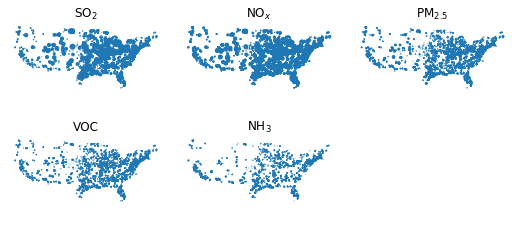

In [5]:
# Finally, lets make some maps of the emissions.

import matplotlib.pyplot as plt
%matplotlib inline

pols = ["SOx", "NOx", "PM2_5", "VOC", "NH3"]
pol_names = ["SO$_2$", "NO$_x$", "PM$_{2.5}$", "VOC", "NH$_3$"]

fig, axes = plt.subplots(figsize=(7, 3), nrows=2, ncols=3, sharex=True, sharey=True)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.1)

i = 0
for x in axes:
    for ax in x:
        if i < len(pols):
            emis.plot(ax=ax, markersize=emis[pols[i]]**0.5 / 5)
            ax.set_title(pol_names[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        i = i+1
plt.show()

Fig. 1: US year-2016 electricity generators. Areas of dots are proportionate to rate of emissions of each pollutant.

These maps could be improved by adding politcal boundaries, etc. We will leave that as an exercise for the reader.

## Use SR matrices to estimate concentrations and health impacts

Once we have our emissions in GeoPandas format, we are ready to run them through our SR matrices.
To do this, we will use the `run_sr` function in the `sr_util.py` script that we have created for this purpose. You can view `sr_util.py` [here](https://github.com/spatialmodel/inmap/blob/master/website/static/blog/2019-04-20-sr/sr_util.py), and if you want to run the code here you will need to download the file into the directory you are working in.

The `run_sr` function takes several arguments, which we will describe here.

* `emis`: A geopandas dataframe of emissions, like the one we've prepared here.

* `model`: Which SR matrix to use. Currently the ISRM (Goodkind et al. paper above) and APSCA (Heo et al. paper above) models are available. The options for this argument are:
    * `isrm`: The InMAP SR matrix
    * `apsca_q0`: The APSCA SR matrix, annual average
    * `apsca_q1`: The APSCA SR matrix, Jan-Mar season
    * `apsca_q2`: The APSCA SR matrix, Apr-Jun season
    * `apsca_q3`: The APSCA SR matrix, Jul-Sep season
    * `apsca_q4`: The APSCA SR matrix, Oct-Dec season
    
* `emis_units`: The units that the emissions are in. Allowed values: `tons/year`, `kg/year`, `ug/s`, and `μg/s`. We will use tons/year, because those are the units our data are in.

* `output_variables`: The information we want the model to output, input as a dictionary in the form {"variable_name": "formula"}. Refer [here](https://inmap.run/docs/results/) for more information regarding formulas. The native model variables available in the SR matrices for use in output formulas are:
    * `PrimaryPM25`: Calculated primary PM<sub>2.5</sub> concentration (μg/m³)
    * `pNH4`: Calculated particulate NH<sub>4</sub> concentration (μg/m³)
    * `pSO4`: Calculated particulate SO<sub>4</sub> concentration (μg/m³)
    * `pNO3`: Calculated particulate NO</sub>3</sub> concentration (μg/m³)
    * `SOA`: Calculated secondary organic aerosol concentration (μg/m³)
    * `Asian`: Year 2010 Asian Population (people/grid cell)
    * `Black`: Year 2010 Black Population (people/grid cell)
    * `Latino`: Year 2010 Latino Population (people/grid cell)
    * `Native`: Year 2010 Native Population (people/grid cell)
    * `TotalPop`: Year 2010 total Population (people/grid cell)
    * `WhiteNoLat`: Year 2010 White non-Latino Population (people/grid cell)
    * `MortalityRate`: Year 2005 baseline overall population mortality rate (deaths per year per 100,000 people)
    * `Baseline NH3`: Baseline NH3 Concentration (μg/m³)
    * `Baseline NOx`: Baseline NOx Concentration (μg/m³)
    * `Baseline SOA`: Baseline SOA Concentration (μg/m³)
    * `Baseline SOx`: Baseline SOx Concentration (μg/m³)
    * `Baseline TotalPM25`: Baseline TotalPM25 Concentration (μg/m³)
    * `Baseline VOC`: Baseline VOC Concentration (μg/m³)
    * `Baseline pNH4`: Baseline pNH4 Concentration (μg/m³)
    * `Baseline pNO3`: Baseline pNO3 Concentration (μg/m³)
    * `Baseline pSO4`: Baseline pSO4 Concentration (μg/m³)
    * `Asian`: Year 2010 Asian Population (people/grid cell)
    * `Black`: Year 2010 Black Population (people/grid cell)
    * `Latino`: Year 2010 Latino Population (people/grid cell)
    * `Native`: Year 2010 Native Population (people/grid cell)
    * `TotalPop`: Year 2010 total Population (people/grid cell)
    * `WhiteNoLat`: Year 2010 White non-Latino Population (people/grid cell)
    * `UAvg`: Average East-West wind speed (m/s)
    * `VAvg`: Average North-South wind speed (m/s)
    * `WAvg`: Average up-down wind speed (m/s)
    * `UDeviation`: Average deviation from East-West velocity (m/s)
    * `VDeviation`: Average deviation from North-South velocity (m/s)
    * `AOrgPartitioning`: Organic particle partitioning (-)
    * `SPartitioning`: Sulfur particle partitioning (-)
    * `NOPartitioning`: Nitrate particle partitioning (-)
    * `NHPartitioning`: Ammonium particle partitioning (-)
    * `SO2oxidation`: SO2 oxidation to SO4 by HO and H2O2 (1/s)
    * `ParticleWetDep`: Particle wet deposition (1/s)
    * `SO2WetDep`: SO2 wet deposition (1/s)
    * `OtherGasWetDep`: Wet deposition: other gases (1/s)
    * `ParticleDryDep`: Particle dry deposition (m/s)
    * `NH3DryDep`: Ammonia dry deposition (m/s)
    * `SO2DryDep`: SO2 dry deposition (m/s)
    * `VOCDryDep`: VOC dry deposition (m/s)
    * `NOxDryDep`: NOx dry deposition (m/s)
    * `Kzz`: Grid center vertical diffusivity after applying convective fraction (m²/s)
    * `Kxxyy`: Grid center horizontal diffusivity (m²/s)
    * `M2u`: ACM2 upward mixing (Pleim 2007)  (1/s)
    * `M2d`: ACM2 downward mixing (Pleim 2007) (1/s)
    * `Dx`: Cell x length (m)
    * `Dy`: Cell y length (m)
    * `Dz`: Cell z length (m)
    * `Volume`: Cell volume (m³)
    * `Temperature`: Average temperature (K)
    * `WindSpeed`: RMS wind speed (m/s)
    * `WindSpeedInverse`: RMS wind speed inverse (s/m)
    * `WindSpeedMinusThird`: RMS wind speed^(-1/3)
    * `WindSpeedMinusOnePointFour`: RMS wind speed^(-1.4)
    * `S1`: Stability parameter (?)
    * `SClass`: Stability class (0=Unstable; 1=Stable)
    * `N`: N grid cell edge (m)
    * `S`: S grid cell edge (m)
    * `E`: E grid cell edge (m)
    * `W`: W grid cell edge (m)

You can probably see that there are an infinite number of output variables that could be calculated. For this example, we will output three variables:

1. `TotalPM25 = PrimaryPM25 + pNH4 + pSO4 + pNO3 + SOA`: In this equation, we are summing up all the different types of PM<sub>2.5</sub> that the model calculates to get total PM<sub>2.5</sub>.

2. `deathsK = (exp(log(1.06)/10 * TotalPM25) - 1) * TotalPop * 1.0465819687408728 * MortalityRate / 100000 * 1.025229357798165` In this equation, we are using the total PM<sub>2.5</sub> value we calculated above in a [Cox proportional hazards](https://en.wikipedia.org/wiki/Proportional_hazards_model) equation, along with information on population counts (`TotalPop`) and baseline mortality rates (`MortalityRate / 100000`) to calculate the number of deaths.
    * 1.0465819687408728 is the ratio between year-2016 population (what we want) and year-2010 population (what the model has).
    * 1.025229357798165 is the ratio between year-2016 mortality rate (what we want) and year-2005 mortality rate (what the model has).
    * The value 1.06 represents an assumption that overall mortality rate increases by 6% for every 10 μg/m³ increase in PM<sub>2.5</sub> concentration, which is taken from [this](https://www.healtheffects.org/publication/extended-follow-and-spatial-analysis-american-cancer-society-study-linking-particulate) paper.
    * The variable name, `deathsK`, comes from the fact that we're calculating deaths and that the 1.06 value comes from a report authored by Krewski et al.

3. `deathsL = (exp(log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.0465819687408728 * MortalityRate * 1.025229357798165 / 100000`: This is the same equation as the previous one, except we assume a 14% increase in morality rate for every 10 μg/m³ increase in PM<sub>2.5</sub> concentration, as [reported by LePeule et al](https://ehp.niehs.nih.gov/doi/full/10.1289/ehp.1104660).

In [6]:
# This step might take a while.

from sr_util import run_sr # This allows us to use the 'run_sr' function 
                           # in the 'sr_util.py' file in this same directory.

output_variables = {
    'TotalPM25':'PrimaryPM25 + pNH4 + pSO4 + pNO3 + SOA',
    'deathsK':'(exp(log(1.06)/10 * TotalPM25) - 1) * TotalPop * 1.0465819687408728 * MortalityRate / 100000 * 1.025229357798165',
    'deathsL':'(exp(log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.0465819687408728 * MortalityRate / 100000 * 1.025229357798165',
}

resultsISRM = run_sr(emis, model="isrm", emis_units="tons/year", output_variables=output_variables)

Finished (626 seconds)                               


In [7]:
resultsAPSCA = run_sr(emis, model="apsca_q0", emis_units="tons/year", output_variables=output_variables)

Finished (371 seconds)                          


## Summarizing results

Now that we have our results, the first thing we can do is sum up the number of deaths we are calculating:

In [8]:
import pandas as pd

deaths = pd.DataFrame.from_dict({
    "Model": ["ISRM", "APSCA"],
    "Krewski Deaths": [resultsISRM.deathsK.sum(), resultsAPSCA.deathsK.sum()],
    "LePeule Deaths": [resultsISRM.deathsL.sum(), resultsAPSCA.deathsL.sum()],
})

deaths

,Model,Krewski Deaths,LePeule Deaths
0,ISRM,6928.959583,15623.924632
1,APSCA,6035.354385,13598.336851


We're calculating somewhere between 6,000 and 16,000 deaths every year caused by air pollution emissions from electricity generators. 

We can also estimate equivalent economic damages using a metric called Value of a Statistical Life, which we will take to be $9 million.

In [9]:
vsl = 9.0e6

pd.DataFrame.from_dict({
    "Model": ["ISRM", "APSCA"],
    "Krewski Damages": deaths["Krewski Deaths"] * vsl,
    "LePeule Damages": deaths["LePeule Deaths"] * vsl,
})

,Model,Krewski Damages,LePeule Damages
0,ISRM,6.236064e+10,1.406153e+11
1,APSCA,5.431819e+10,1.223850e+11


So the health damages from power plants are equivalent to between 50 and 140 billion dollars per year. By using multiple SR matrices and multiple esitimates of the relationship between concentrations and mortality rate, we're able to estimate the uncertainty in our results.

The final thing we'll do here is to make maps of our concentration results:

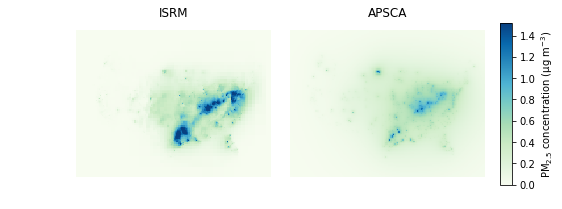

In [10]:
import numpy as np

q = 0.995 # We are going to truncate our results at the 99.5th percentile
          # to make the maps easier to interpret.
cut = resultsISRM.TotalPM25.append(resultsAPSCA.TotalPM25, ignore_index=True).quantile(q)


fig, axes = plt.subplots(figsize=(7, 2.5), nrows=1, ncols=2, sharex=True, sharey=True)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

# Create the color bar.
im1 = axes[0].imshow(np.random.random((10,10)), vmin=0, cmap="GnBu", vmax=cut)
fig.subplots_adjust(right=0.85)
cbar_ax1 = fig.add_axes([0.86, 0.05, 0.025, 0.9])
c1 = fig.colorbar(im1, cax=cbar_ax1)
c1.ax.set_ylabel('PM$_{2.5}$ concentration (μg m$^{-3}$)')
axes[0].clear()

resultsISRM.plot(ax=axes[0], vmin=0, vmax=cut, cmap="GnBu", column="TotalPM25")
resultsAPSCA.plot(ax=axes[1], vmin=0, vmax=cut, cmap="GnBu", column="TotalPM25")

axes[0].axis('off')
axes[1].axis('off')

axes[0].set_title("ISRM")
axes[1].set_title("APSCA")

plt.show()

Fig. 2: PM<sub>2.5</sub> concentrations caused by electricity generation in the US.

As above, the maps would be better if political boundaries were added for reference, but we will leave that as homework, as there are other tutorials out there that describe how to do that.

## Conclusion

Hopefully this tutorial has given you the information you need to do your own air pollution analyses using SR matrices. If not, you can browse the documentation at https://inmap.run or contact the InMAP users group at https://groups.google.com/forum/#!forum/inmap-users.